## Import des librairies et des fichiers

In [1]:
import requests
import pandas as pd
import json
import numpy as np
import plotly.graph_objects as gp
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from datetime import date,timedelta


In [2]:
# Import des résultats du ratissage de Babelio

df=pd.read_json("books-sample1.json",lines=True)

In [18]:
# Import du lexique des émotions et transformation en dictionnaire

emotions=pd.read_csv("lexique_emotions.csv",delimiter=";")
dict_emotions={m:s for m,s in zip(emotions["mot"].tolist(),emotions["sentiment"].tolist())}
dict_emotions

{'rage': 'colère',
 'fureur': 'colère',
 'insupportable': 'colère',
 'exaspération': 'colère',
 'exaspérant': 'colère',
 'exaspérante': 'colère',
 'agacement': 'colère',
 'agaçant': 'colère',
 'agaçante': 'colère',
 'contrariété': 'colère',
 'courroux': 'colère',
 'âpre': 'colère',
 'férocité': 'colère',
 'dureté': 'colère',
 'brutalité': 'colère',
 'brutal': 'colère',
 'brutale': 'colère',
 'froideur': 'colère',
 'sauvage': 'colère',
 'vengée': 'colère',
 'vengé': 'colère',
 'cruel': 'colère',
 'cruelle': 'colère',
 'cruauté': 'colère',
 'vengeance': 'colère',
 'ressentiment': 'colère',
 'rancœur': 'colère',
 'grogne': 'colère',
 'hargne': 'colère',
 'irritation': 'colère',
 'irritée': 'colère',
 'irrité': 'colère',
 'massacre': 'colère',
 'fâché': 'colère',
 'furieux': 'colère',
 'carnage': 'colère',
 'furibond': 'colère',
 'révoltant': 'colère',
 'révoltante': 'colère',
 'révolte': 'colère',
 'révolté': 'colère',
 'révoltée': 'colère',
 'outragé': 'colère',
 'offensée': 'colère',
 '

In [4]:
# Import et chargement de la librairie Spacy en français

import spacy
nlp = spacy.load("fr_core_news_sm")

c:\Users\antoi\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'fr_core_news_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Prétraitement de texte

In [5]:
# Retrait des retour-chariot dans les commentaires

df["commentaire"]=df["commentaire"].apply(lambda x : x.replace("\n","").replace("\t",""))

In [6]:
#df["commentaire"]=df["commentaire"].apply(lambda x : " ".join(x))

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# Retrait des caractères spéciaux et mise en minuscules des mots

df['com_process'] = df['commentaire'].str.replace(r"[!\"#$%&()*+,-./:;•♪♫<=>«»?@[\\\]^_`{|}~]+", " ")
df['com_process'] = df['com_process'].fillna('').apply(lambda x: x.lower())
df.head(5)

C:\Users\antoi\AppData\Local\Temp\ipykernel_9448\3564798599.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['com_process'] = df['commentaire'].str.replace(r"[!\"#$%&()*+,-./:;•♪♫<=>«»?@[\\\]^_`{|}~]+", " ")


,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,note,date,appreciations,commentaire,com_process
0,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2080694,706958,4.0,30 novembre 2019,85,Roadtrip désertique dans l'Ouest Américain en ...,roadtrip désertique dans l'ouest américain en ...
1,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1271915,319761,5.0,03 mars 2017,68,"De temps en temps, j'aime bien revenir vers l'...",de temps en temps j'aime bien revenir vers l'...
2,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1093854,128814,5.0,27 juin 2016,67,"Depuis peu j'ai découvert grâce à "" Cardabelle...",depuis peu j'ai découvert grâce à cardabelle...
3,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2711430,227017,4.5,22 juillet 2021,64,"Ils sont quatre. Une blonde , jeunette, venue ...",ils sont quatre une blonde jeunette venue ...
4,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2685514,138438,4.5,26 juin 2021,64,Avez-vous entendu cette info effrayante ? « La...,avez vous entendu cette info effrayante la...


In [9]:
#df['commentaire'].str.replace('[^A-zA-ù0-9]', ' ', regex=True)

In [10]:
df["note"]=df["note"].replace("",np.nan)

In [11]:
df["note"]=df["note"].astype("float")

In [12]:
df["note_p"]=df["note"]/5

In [13]:
# Import des mots-vides de la langue française

from spacy.lang.fr.stop_words import STOP_WORDS as mots_vides

In [14]:
# Ajout de certains mots récurrents aux mots-vides

nlp.Defaults.stop_words.add("d")
nlp.Defaults.stop_words.add("l")
nlp.Defaults.stop_words.add("n")
nlp.Defaults.stop_words.add("livre")
nlp.Defaults.stop_words.add("roman")
nlp.Defaults.stop_words.add("auteur")
nlp.Defaults.stop_words.add("personnage")
nlp.Defaults.stop_words.add("personnages")

In [15]:
# Ajout des noms et prénoms des auteurs et autrices aux mots-vides

for e in df["name"].unique():
    nlp.Defaults.stop_words.add(str.lower(e))

for e in df["surname"].unique():
    nlp.Defaults.stop_words.add(str.lower(e))

In [16]:
# Tokenization des commentaires en prétraitement

tokenized_doc = df['com_process'].fillna('').apply(lambda x: nlp(x))



KeyboardInterrupt: 

In [ ]:
# Retrait effectif des mots-vides

df["tokenized"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides])

In [ ]:
# Finalisation du prétraitement de texte des commentaires

df["com_final"] = tokenized_doc.apply(lambda x: ' '.join(str(v) for v in x))

In [ ]:
# Isolement des mots liés aux sentiments répertoriés dans le dictionnaire des émotions

df["filtre_sentiments"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])


In [ ]:
# Identification des sentiments correspondants

df["sentimentest"] = tokenized_doc.apply(lambda x: [dict_emotions[token.text] for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])


In [ ]:
# Finalisation du prétraitement focalisé sur les sentiments

df["sentiments_final"] = df["sentimentest"].apply(lambda x: ' '.join(str(v) for v in x))

In [ ]:
#ds["filtre_sentiments"] = tokenized_doc.apply(lambda x: [token for token in x if token.text not in mots_vides and token.text in dict_emotions.keys()])

In [ ]:
df["tokenized_doc"]=tokenized_doc

In [ ]:
# Enregistrement du dataframe au format csv pour utilisations futures

df.to_csv("df_nlp.csv",encoding="utf-8")

In [ ]:
dtest=pd.read_csv("df_nlp.csv")
dtest.head(2)

,Unnamed: 0,book_id,book_nb_comm,title,name,surname,tags,img_url,comm_id,user_id,...,appreciations,commentaire,note_p,com_process,tokenized,filtre_sentiments,sentimentest,sentiments_final,com_final,tokenized_doc
0,0,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,2080694,706958,...,85,Roadtrip désertique dans l'Ouest Américain en ...,0.8,roadtrip désertique dans l'ouest américain en ...,"[roadtrip, désertique, ouest, américain, compa...","[furieux, plaisir]","['colère', 'joie']",colère joie,roadtrip désertique dans l' ouest américain en...,roadtrip désertique dans l'ouest américain en ...
1,1,905033,137,"Le gang de la clef à molette (Ne meurs pas, ô ...",Edward,Abbey,"roman,romans policiers et polars,thriller,colo...",/couv/CVT_cvt_Le-gang-de-la-clef-a-molette_345...,1271915,319761,...,68,"De temps en temps, j'aime bien revenir vers l'...",1.0,de temps en temps j'aime bien revenir vers l'...,"[temps, temps, , aime, bien, revenir, oeuvre,...","[réflexion, intelligent, bonheur, plaisir, rir...","['réflexion', 'réflexion', 'joie', 'joie', 'jo...",réflexion réflexion joie joie joie peur joie,de temps en temps j' aime bien revenir vers ...,de temps en temps j'aime bien revenir vers l'...


In [ ]:
def return_POS(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner les étiquettes de chaque token
    return [(X, X.pos_) for X in doc]

In [ ]:
dict={pos[0].text:pos[1] for pos in return_POS(df.loc[0,"com_final"])}

In [ ]:
adjectifs=[m for m in dict if dict[m]=="ADJ"]

## Analyse exploratoire

In [ ]:
import matplotlib.pyplot as plt
import wordcloud

In [ ]:
doc=nlp(df.loc[0,"com_final"])

In [ ]:
random_title = np.random.choice(df["title"].unique())
random_title

'Le gone du Chaâba'

In [ ]:
ndm = nlp(" ".join(df[df["title"]==random_title].loc[:,"sentiments_final"].tolist()))

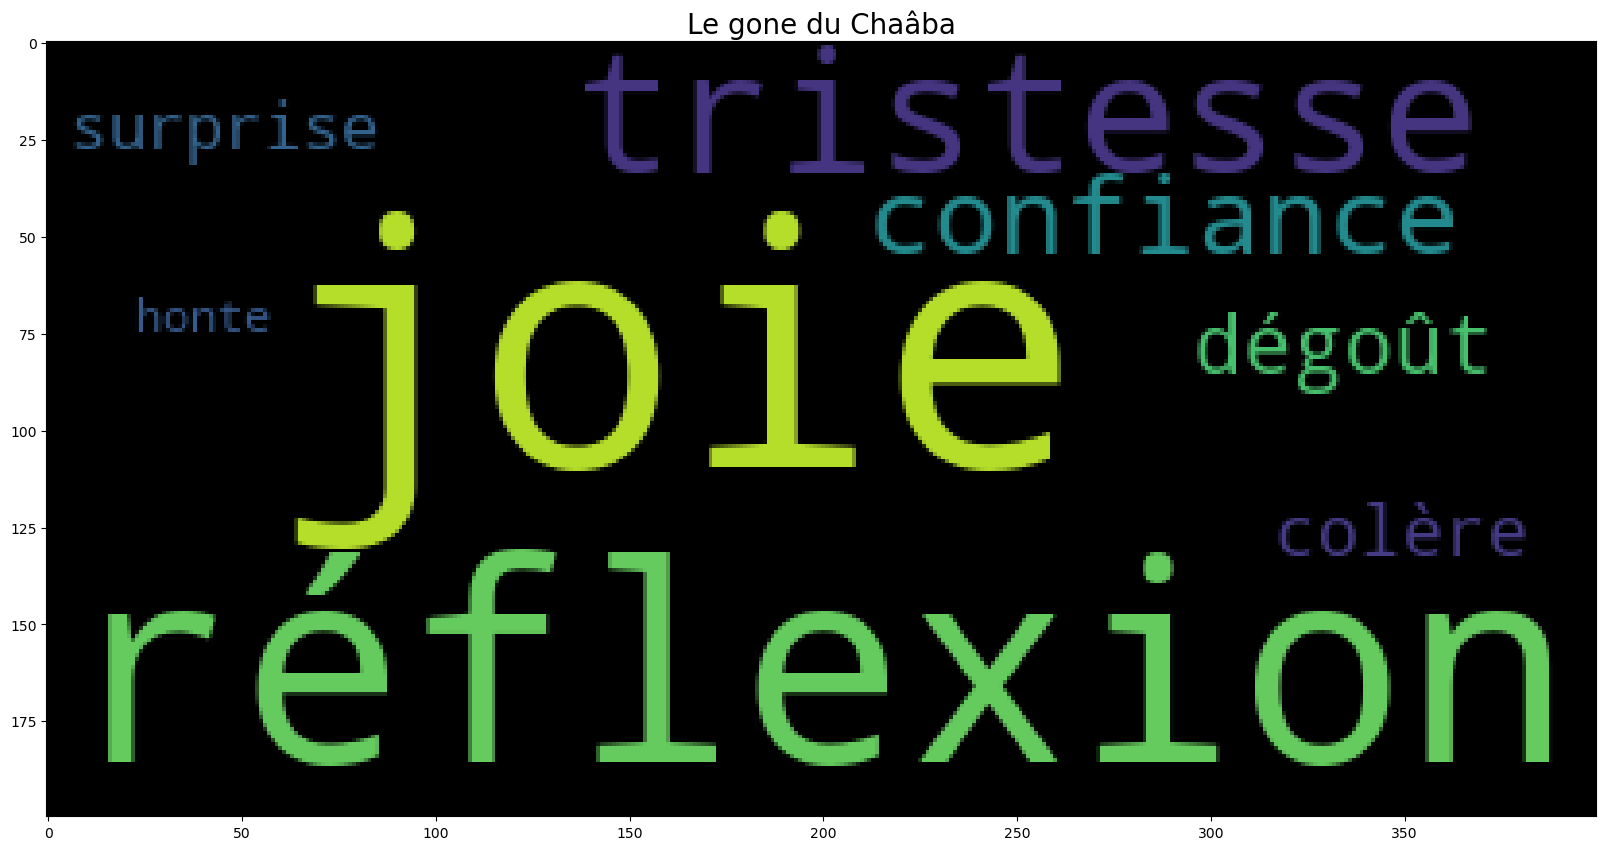

In [ ]:
wd = wordcloud.WordCloud()
cloud = wd.generate(ndm.text)

# Show word cloud with matplotlib 
plt.figure(figsize=(20,20))
plt.imshow(cloud)
plt.title(random_title,fontsize=20)


# Remove trailing logs 
plt.show()

## Création des vecteurs de sentiments

In [ ]:
# Import de TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
liste_emotions=["joie","confiance","surprise","peur","tristesse","colère","honte","réflexion"]

dict_vect = {}

for title in df["title"].unique():
    tfidf = tfidf_vectorizer.fit_transform(df[df["title"] == title].loc[:, "sentiments_final"].tolist())
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf.toarray(), columns=[x for x in tfidf_vectorizer.get_feature_names_out()]).reset_index()
    df_def = df_tfidf.describe().T.iloc[1:,:]["mean"]
    df_to_vec = pd.DataFrame({"title":[title]*len(liste_emotions),
                              "emotion":liste_emotions,
                              "valeur":[df_def.loc[em] if em in df_def.index else 0 for em in liste_emotions]
                             })
    df_to_vec["poids_valeur"] = df_to_vec["valeur"]/df_to_vec["valeur"].sum()
    dict_vect[title] = df_to_vec



In [ ]:
df_tfidf.describe().T

,count,mean,std,min,25%,50%,75%,max
index,44.0,21.500000,12.845233,0.0,10.750000,21.500000,32.250000,43.000000
colère,44.0,0.109015,0.243614,0.0,0.000000,0.000000,0.000000,0.922298
confiance,44.0,0.212537,0.267561,0.0,0.000000,0.000000,0.387312,0.941942
dégoût,44.0,0.047456,0.186436,0.0,0.000000,0.000000,0.000000,1.000000
joie,44.0,0.517813,0.338768,0.0,0.287931,0.582902,0.779871,1.000000
peur,44.0,0.100873,0.230049,0.0,0.000000,0.000000,0.000000,0.835581
réflexion,44.0,0.151471,0.236434,0.0,0.000000,0.000000,0.312203,0.941184
surprise,44.0,0.206700,0.329050,0.0,0.000000,0.000000,0.368468,1.000000
tristesse,44.0,0.155295,0.255157,0.0,0.000000,0.000000,0.284228,0.899894


In [ ]:
df_vect = pd.concat(dict_vect.values())


In [ ]:
df_vect

,title,emotion,valeur,poids_valeur
0,"Le gang de la clef à molette (Ne meurs pas, ô ...",joie,0.501351,0.309961
1,"Le gang de la clef à molette (Ne meurs pas, ô ...",confiance,0.195264,0.120722
2,"Le gang de la clef à molette (Ne meurs pas, ô ...",surprise,0.090716,0.056086
3,"Le gang de la clef à molette (Ne meurs pas, ô ...",peur,0.088190,0.054523
4,"Le gang de la clef à molette (Ne meurs pas, ô ...",tristesse,0.174443,0.107850
...,...,...,...,...
3,"Une enquête de William Wisting, tome 5 : Le co...",peur,0.100873,0.069390
4,"Une enquête de William Wisting, tome 5 : Le co...",tristesse,0.155295,0.106827
5,"Une enquête de William Wisting, tome 5 : Le co...",colère,0.109015,0.074991
6,"Une enquête de William Wisting, tome 5 : Le co...",honte,0.000000,0.000000


In [ ]:
from scipy import spatial

In [ ]:
"Comment braquer une banque sans perdre son dentier"
"Rebecca Kean, tome 5 : L'armée des âmes"

In [ ]:
v1 = df_vect[df_vect["title"]=="Comment braquer une banque sans perdre son dentier"]["poids_valeur"].tolist()
v2 = df_vect[df_vect["title"]=="Rebecca Kean, tome 5 : L'armée des âmes"]["poids_valeur"].tolist()
print(v1)
print(v2)
1 - spatial.distance.cosine(v1, v2)

[0.3525728923278647, 0.09458627021510715, 0.10211107970813056, 0.019075493659031176, 0.14703831340830734, 0.04221628384694447, 0.0, 0.24239966683461456]
[0.3791257035005228, 0.12963805071697757, 0.11012607314329811, 0.03894663207377297, 0.1244840036768519, 0.09726075629176774, 0.013346052759951968, 0.10707272783685697]


0.944699474171264

In [ ]:
random_title = np.random.choice(df_vect["title"].unique())
print(random_title)
random_title2 = np.random.choice(df_vect["title"].unique())
print(random_title2)
v1 = df_vect[df_vect["title"]==random_title]["poids_valeur"].tolist()
v2 = df_vect[df_vect["title"]==random_title2]["poids_valeur"].tolist()
print(v1)
print(v2)
1 - spatial.distance.cosine(v1, v2)

La fissure
Où bat le coeur du monde
[0.281279814605877, 0.09461435622376607, 0.1417607828526777, 0.026503417744123514, 0.09763056791052624, 0.08456929774253419, 0.0, 0.2736417629204953]
[0.3396758820149665, 0.11694280274546727, 0.09351191566964537, 0.04521460584157959, 0.1407335239948127, 0.09000185767945182, 0.0, 0.17391941205407682]


0.9537898097671899

In [ ]:
v1 = df_vect[df_vect["title"]==random_title]["valeur"].tolist()
v2 = df_vect[df_vect["title"]==random_title2]["valeur"].tolist()
print(v1)
print(v2)
1 - spatial.distance.cosine(v1, v2)

[0.45903686980357045, 0.154406664339895, 0.23134765682626843, 0.04325246707591036, 0.15932899541187517, 0.1380135498582199, 0.0, 0.4465718895419465]
[0.5906423142355575, 0.20334492763231193, 0.16260234301028778, 0.07862100562777795, 0.2447132066301929, 0.15649891063784285, 0.0, 0.3024181858798597]


0.95378980976719

In [ ]:
fig = px.line_polar(df_vect[df_vect["title"]=="random_title"],r=df_vect[df_vect["title"]==random_title]["valeur"],theta=df_vect[df_vect["title"]==random_title]["emotion"],
                    line_close=True, range_r=[0,max(df_vect[df_vect["title"]==random_title]["valeur"])+0.1],title=random_title)
fig.show()

c:\Users\antoi\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

